In [2]:
import sys
sys.path.append('..')

import torch

from models.vision_transformer import ViT

import matplotlib.pyplot as plt
import pandas as pd

# Pruning by Layer

In [4]:
model = ViT(
    img_size = 256, 
    patch_size = 4, 
    tubelet_size = 2, 
    in_chans = 2, 
    encoder_embed_dim = 192,
    encoder_depth = 4,
    encoder_num_heads = 4,
    decoder_embed_dim = 96,
    decoder_depth = 4, 
    decoder_num_heads = 4, 
    mlp_ratio = 4.0,
    num_frames = 2,
    num_out_frames = 1,
    patch_recovery = "subpixel_conv"
)

checkpoint_path = "/glade/derecho/scratch/jshen/pruning-turbulence-vit/base/prune_plateau_early_stop/pruned_models/48.tar"
state_dict = torch.load(checkpoint_path, map_location='cpu')

for key in state_dict.keys():
    if key.endswith('_orig') or key.endswith('_mask'):
        import torch.nn.utils.prune as prune
        prune.global_unstructured(
            model.get_parameters_to_prune(), 
            pruning_method=prune.Identity
        )

# Check if state dict is distributed

try:
    model.load_state_dict(state_dict)
except:
    state_dict = {
        k.replace("module.", ""): v
        for k, v in state_dict.items()
    }
    model.load_state_dict(state_dict)

model.eval()

ViT(
  (patch_embed): PatchEmbed(
    (proj): Conv3d(2, 192, kernel_size=(2, 4, 4), stride=(2, 4, 4))
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (encoder_blocks): ModuleList(
    (0-3): 4 x Block(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (proj): Linear(in_features=192, out_features=192, bias=True)
      )
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=768, out_features=192, bias=True)
      )
    )
  )
  (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (decoder_embed): Linear(in_features=192, out_features=96, bias=True)
  (decoder_blocks): ModuleList(
    (0-3): 4 x Block(
      (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=Tru

In [5]:
def pruning_by_layer(model):
    modules = {
        module_name: [] for module_name in 
        ['Q', 'K', 'V', 'proj', 'W_up', 'W_down', 'bias_up', 'bias_down']
    }

    for block_index, block in enumerate(model.encoder_blocks + model.decoder_blocks):

        attn = block.attn
        _, d_embed = attn.qkv.weight.shape
        qkv_mask = attn.qkv.weight_mask.reshape(d_embed, 4, 3, d_embed//4)
        q_mask, k_mask, v_mask = qkv_mask.unbind(dim=2)

        modules['Q'].append((1 - q_mask.sum() / q_mask.numel()).item())
        modules['K'].append((1 - k_mask.sum() / k_mask.numel()).item())
        modules['V'].append((1 - v_mask.sum() / v_mask.numel()).item())
        modules['proj'].append((1 - attn.proj.weight_mask.sum() / attn.proj.weight_mask.numel()).item())
        modules['W_up'].append((1 - block.mlp.fc1.weight_mask.sum() / block.mlp.fc1.weight_mask.numel()).item())
        modules['W_down'].append((1 - block.mlp.fc2.weight_mask.sum() / block.mlp.fc2.weight_mask.numel()).item())
        modules['bias_up'].append((1 - block.mlp.fc1.bias_mask.sum() / block.mlp.fc1.bias_mask.numel()).item())
        modules['bias_down'].append((1 - block.mlp.fc2.bias_mask.sum() / block.mlp.fc2.bias_mask.numel()).item())

    return pd.DataFrame(modules)

all_data = pruning_by_layer(model)

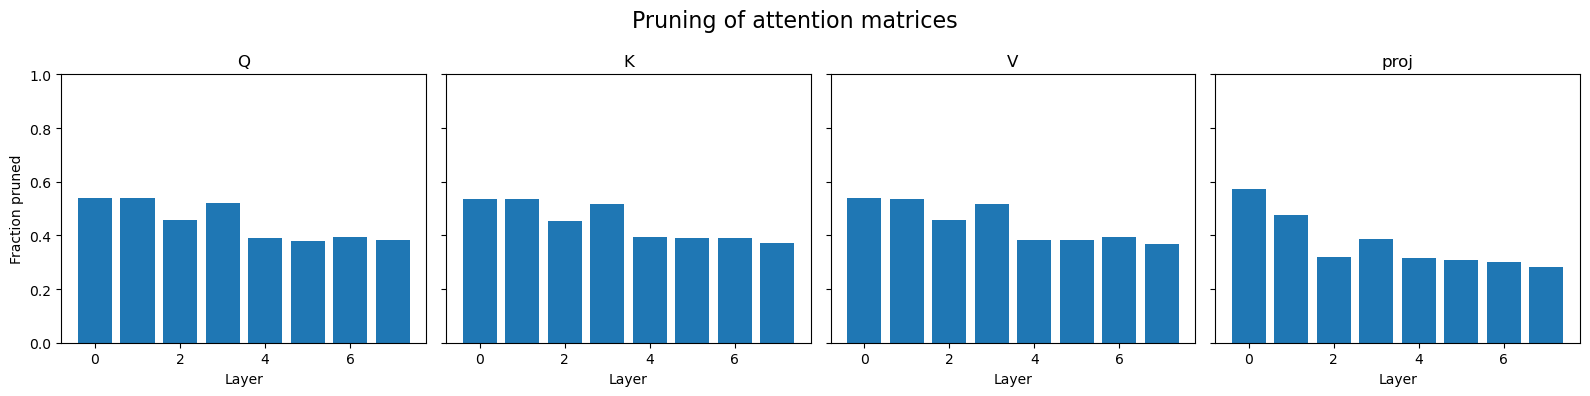

In [6]:
attn_data = all_data[['Q', 'K', 'V', 'proj']]

fig, axs = plt.subplots(1, attn_data.shape[1], figsize=(attn_data.shape[1] * 4, 4), sharey=True)

for i, ax in enumerate(axs):
    ax.bar(range(attn_data.shape[0]), attn_data.iloc[:, i])
    ax.set_ylim([0, 1])
    ax.set_title(attn_data.columns[i])
    ax.set_xlabel('Layer')

axs[0].set_ylabel('Fraction pruned')
fig.suptitle('Pruning of attention matrices', fontsize=16)
fig.tight_layout()

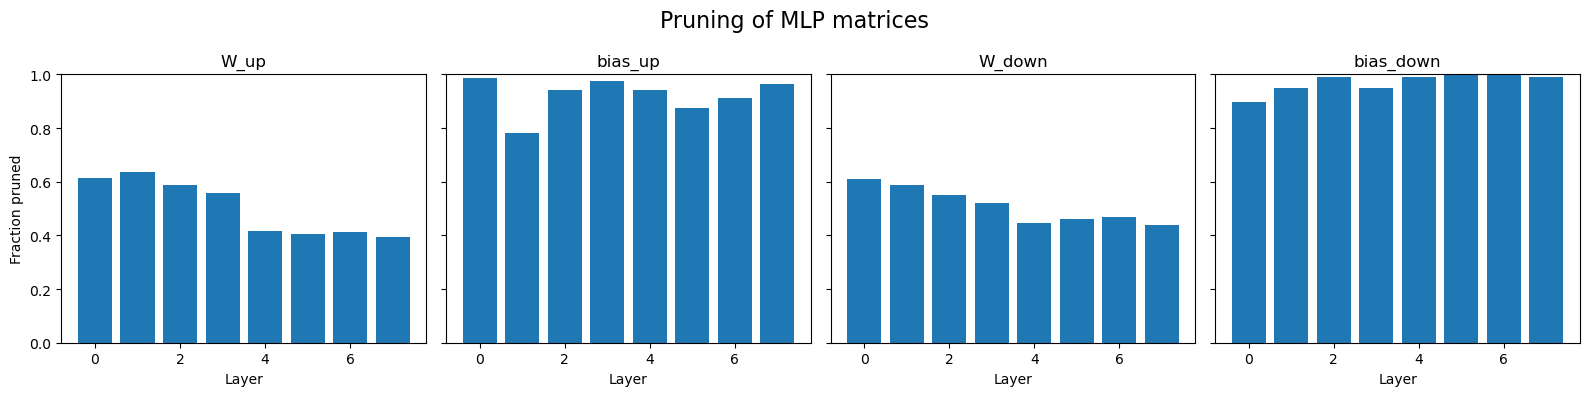

In [7]:
attn_data = all_data[['W_up', 'bias_up', 'W_down', 'bias_down']]

fig, axs = plt.subplots(1, attn_data.shape[1], figsize=(attn_data.shape[1] * 4, 4), sharey=True)

for i, ax in enumerate(axs):
    ax.bar(range(attn_data.shape[0]), attn_data.iloc[:, i])
    ax.set_ylim([0, 1])
    ax.set_title(attn_data.columns[i])
    ax.set_xlabel('Layer')

axs[0].set_ylabel('Fraction pruned')
fig.suptitle('Pruning of MLP matrices', fontsize=16)
fig.tight_layout()

# Pruning by Iteration

In [7]:
model = ViT(
    img_size = 256, 
    patch_size = 4, 
    tubelet_size = 2, 
    in_chans = 2, 
    encoder_embed_dim = 192,
    encoder_depth = 4,
    encoder_num_heads = 4,
    decoder_embed_dim = 96,
    decoder_depth = 4,
    decoder_num_heads = 4,
    mlp_ratio = 4.0,
    num_frames = 2,
    num_out_frames = 1,
    patch_recovery = "subpixel_conv"
)

In [ ]:
by_iteration = []

for i in range(8):
    print(f'Iteration {i}...', end='')
    checkpoint_path = f"/glade/derecho/scratch/jshen/2d-turbulence-vit/BASE/pruning_checkpoints/iteration_{i}.pt"
    state_dict = torch.load(checkpoint_path, map_location='cpu')

    for key in state_dict.keys():
        if key.endswith('_orig') or key.endswith('_mask'):
            import torch.nn.utils.prune as prune
            prune.global_unstructured(
                model.get_parameters_to_prune(), 
                pruning_method=prune.Identity
            )

    # Check if state dict is distributed

    try:
        model.load_state_dict(state_dict)
    except:
        state_dict = {
            k.replace("module.", ""): v
            for k, v in state_dict.items()
        }
        model.load_state_dict(state_dict)

    model.eval()

    by_layer = pruning_by_layer(model)
    by_iteration.append(by_layer.mean(axis=1))

    print('done.')

by_iteration = pd.DataFrame(by_iteration)
by_iteration.columns = by_layer.columns

Iteration 0...done.
Iteration 1...done.
Iteration 2...done.
Iteration 3...done.
Iteration 4...

: 

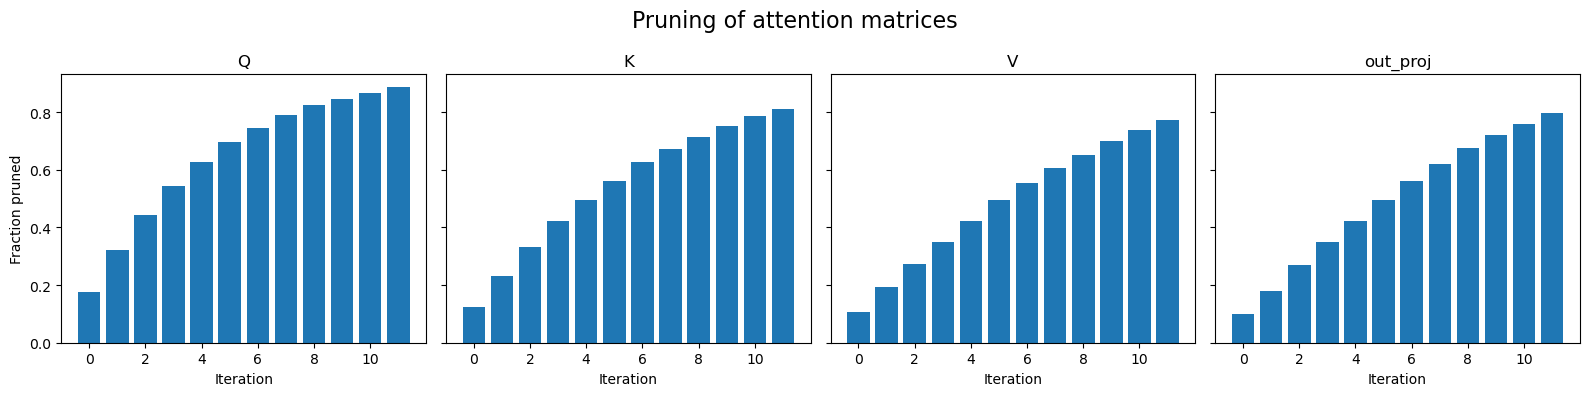

In [ ]:
attn_data = by_iteration[['Q', 'K', 'V', 'out_proj']]

fig, axs = plt.subplots(1, attn_data.shape[1], figsize=(attn_data.shape[1] * 4, 4), sharey=True)

for i, ax in enumerate(axs):
    ax.bar(range(attn_data.shape[0]), attn_data.iloc[:, i])
    ax.set_title(attn_data.columns[i])
    ax.set_xlabel('Iteration')

axs[0].set_ylabel('Fraction pruned')
fig.suptitle('Pruning of attention matrices', fontsize=16)
fig.tight_layout()

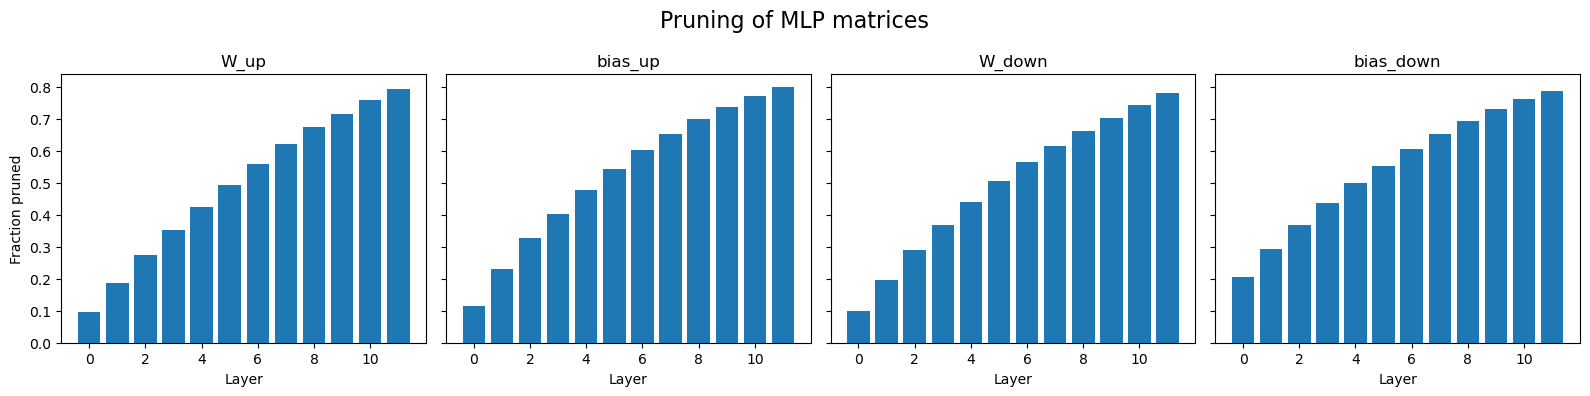

In [ ]:
attn_data = by_iteration[['W_up', 'bias_up', 'W_down', 'bias_down']]

fig, axs = plt.subplots(1, attn_data.shape[1], figsize=(attn_data.shape[1] * 4, 4), sharey=True)

for i, ax in enumerate(axs):
    ax.bar(range(attn_data.shape[0]), attn_data.iloc[:, i])
    ax.set_title(attn_data.columns[i])
    ax.set_xlabel('Layer')

axs[0].set_ylabel('Fraction pruned')
fig.suptitle('Pruning of MLP matrices', fontsize=16)
fig.tight_layout()